In [1]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#img = cv2.imread('hand_prof_1.jpeg', cv.IMREAD_GRAYSCALE)
orig_img = cv2.imread('hand_prof_1.jpeg')

In [3]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [4]:
img = ResizeWithAspectRatio(orig_img, width=900)
cv2.imshow("Resized_Window", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [98]:
def remove_glare(img):
    blr = cv2.medianBlur(img, 15)
    # now grab brightness V of HSV here - but Gray is possibly as good
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    val = hsv[:, :, 2]
    # use ADAPTIVE_THRESH_GAUSSIAN to find spots. 
    # I manually tweaked the values- these seem to work well with what I have.
    at = cv2.adaptiveThreshold(np.array(255 - val), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 17)
    # Now invert the threshold, and run another for edges.
    ia = np.array(255 - at)  # inversion of adaptiveThreshold of the value.
    iv = cv2.adaptiveThreshold(ia, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 9)
    # ib = merged edges with the dots (as an invert mask).
    ib = cv2.subtract(iv, ia)
    # Turn this to a 3 channel mask.
    bz = cv2.merge([ib, ib, ib])
    # Use the blur where the mask is, otherwise use the image.
    dsy = np.where(bz == (0, 0, 0), blr, img)
    result = dsy
    return result

In [6]:

def plot(image, edges): 
    
    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    
    plt.show()

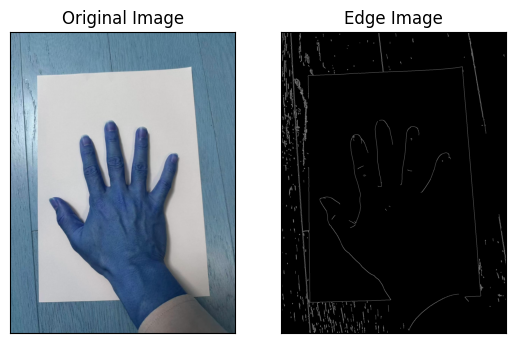

In [142]:
edges = cv.Canny(img,100,220)

plot(img, edges)

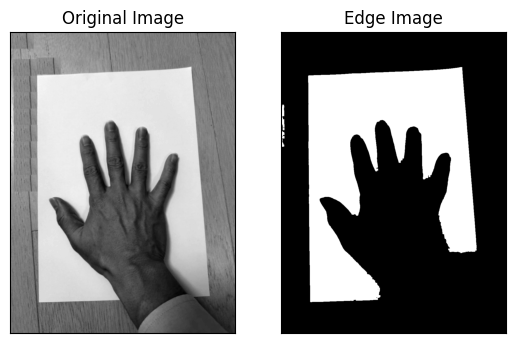

In [8]:
#img = remove_glare(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
_, threshold = cv2.threshold(img_gray, 190, 255, cv2.THRESH_BINARY)
threshold = cv2.erode(threshold, None, iterations=3)
threshold = cv2.dilate(threshold, None, iterations=3)



plot(img_gray, threshold)

In [68]:

output = cv2.connectedComponentsWithStats(
	threshold)
(numLabels, labels, stats, centroids) = output
output1 = img.copy()
# loop over the number of unique connected component labels
for i in range(0, numLabels):
    if i == 0:
        text = "examining component {}/{} (background)".format(i + 1, numLabels)
    else:
        text = "examining component {}/{}".format(i + 1, numLabels)
    print("[INFO] {}".format(text))
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    print("stats: " + str(x) + "," + str(y))
    
    cv2.rectangle(output1, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output1, (int(cX), int(cY)), 4, (0, 0, 255), -1)

    componentMask = (labels == i).astype("uint8") * 255
# show our output image and connected component mask
cv2.imshow("Output", output1)
cv2.imshow("Connected Component", componentMask)
cv2.waitKey(0)

In [13]:
cv2.imshow("test", threshold)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Going through every contours found in the image.
idx = 0

maxc = max(contours, key = cv2.contourArea)
approx = cv2.approxPolyDP(maxc, 0.009 * cv2.arcLength(maxc, True), True)
cv2.drawContours(orig_img, [approx], 0, (0, 0, 255), 1)

n = approx.ravel()
i = 0
for j in n:
    if (i % 2 == 0):
        x = n[i]
        y = n[i + 1]
        string = str(x) + " " + str(y)
        cv2.putText(orig_img, string, (x, y), cv2.FONT_HERSHEY_COMPLEX, .5, (255, 255, 0))
        i = i + 1



cv2.imshow("after contouring", orig_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [211]:
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Going through every contours found in the image.
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
    # draws boundary of contours.
    cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)
    # Used to flatted the array containing
    # the co-ordinates of the vertices.
    n = approx.ravel()
    i = 0
    for j in n:
        if (i % 2 == 0):
            x = n[i]
            y = n[i + 1]
            # String containing the co-ordinates.
            string = str(x) + " " + str(y)
            if (i == 0):
                # text on topmost co-ordinate.
                cv2.putText(img, "Arrow tip", (x, y),
                            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0))
            else:
                # text on remaining co-ordinates.
                cv2.putText(img, string, (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
        i = i + 1
#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  
cv2.imshow("after contouring", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

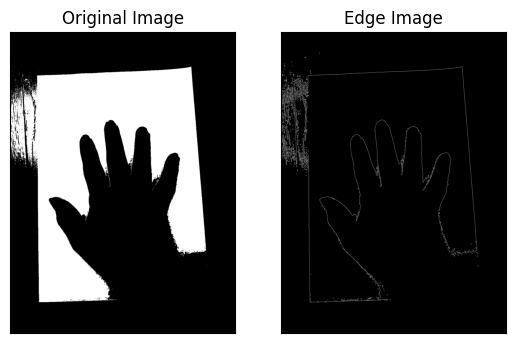

In [85]:
edges = cv.Canny(threshold,0,255)

plot(threshold, edges)